In [1]:
import pandas as pd
from pymongo import MongoClient
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import seaborn as sns

# Connexion MongoDB
client = MongoClient("localhost", 27017)
db = client["IF29_twitter_db"]
user_col = db["twitter_users"]

# Chargement des utilisateurs
users = list(user_col.find())
df_users = pd.DataFrame(users)

# Conversion du champ created_at en datetime avec timezone
df_users["created_at"] = pd.to_datetime(
    df_users["created_at"], format="%a %b %d %H:%M:%S %z %Y", errors="coerce"
)

now_utc = datetime.utcnow().replace(tzinfo=timezone.utc)

# Calcul de l'âge du compte en jours
df_users["account_age_days"] = (now_utc - df_users["created_at"]).dt.days

# Nouveau attributs dérivés
df_users["tweets_per_day"] = df_users["statuses_count"] / (df_users["account_age_days"] + 1)
df_users["friends_active_ratio"] = df_users["friends_count"] / (df_users["followers_count"] + 1)
df_users["followers_friends_ratio"] = df_users["followers_count"] / (df_users["friends_count"] + 1)
df_users["popularity_score"] = df_users["followers_count"] * df_users["followers_friends_ratio"]
df_users["favorites_per_tweet"] = df_users["favourites_count"] / (df_users["statuses_count"] + 1)

# Nettoyage des valeurs infinies et nulles
df_users.replace([float('inf'), -float('inf')], pd.NA, inplace=True)
df_users.dropna(subset=[
    "tweets_per_day", "friends_active_ratio", "popularity_score", "favorites_per_tweet"
], inplace=True)

# Aperçu des nouveaux indicateurs
display(df_users[[
    "tweets_per_day", "friends_active_ratio", "popularity_score", "favorites_per_tweet"
]].describe())

# Pour chaque utilisateur, on met à jour les nouveaux champs dans la base MongoDB
for _, row in df_users.iterrows():
    user_id = row["_id"]  # Identifiant unique MongoDB
    
    update_data = {
        "tweets_per_day": row["tweets_per_day"],
        "friends_active_ratio": row["friends_active_ratio"],
        "followers_friends_ratio": row["followers_friends_ratio"],
        "popularity_score": row["popularity_score"],
        "favorites_per_tweet": row["favorites_per_tweet"],
        "account_age_days": row["account_age_days"]
    }
    
    user_col.update_one(
        {"_id": user_id},
        {"$set": update_data}
    )


,tweets_per_day,friends_active_ratio,popularity_score,favorites_per_tweet
count,267468.000000,267468.000000,2.674680e+05,267468.000000
mean,4.768018,2.593704,6.973299e+08,1.763617
std,11.183684,7.550920,1.244813e+11,19.022112
min,0.000171,0.000000,0.000000e+00,0.000000
25%,0.336529,0.630952,5.482502e+01,0.102323
50%,1.439436,1.160377,3.043442e+02,0.451877
75%,4.756349,2.588235,1.460416e+03,1.218196
max,1352.213493,1715.000000,5.734617e+13,4541.666667


In [2]:
# Trier par popularity_score décroissant
top_influencers = df_users.sort_values(by="popularity_score", ascending=False).head(20)

# Affichage des colonnes clés pour ces influenceurs
display(top_influencers[[
    "screen_name", "followers_count", "friends_count", 
    "statuses_count", "popularity_score", "tweets_per_day", "favorites_per_tweet"
]])


,screen_name,followers_count,friends_count,statuses_count,popularity_score,tweets_per_day,favorites_per_tweet
138460,sabqorg,13116345,2,136570,5.734617e+13,23.558737,0.000000
190038,realmadrid,30755372,54,62442,1.719805e+13,10.029232,0.000304
41774,AjelNews24,7136560,3,179852,1.273262e+13,34.461008,0.001790
35161,FCBarcelona,29274484,72,96067,1.173966e+13,16.987975,0.015177
124824,VogueParis,2546923,0,95826,6.486817e+12,15.647616,0.000083
7136,BBCWorld,23537513,85,279573,6.442029e+12,41.708638,0.000032
49258,ndtv,10843983,19,481882,5.879598e+12,81.924855,0.000000
87199,youm7,7484588,10,623449,5.092642e+12,121.411685,0.000711
230984,Shorouk_News,3673590,2,857105,4.498421e+12,146.263652,0.000012
105928,premierleague,18044196,77,93032,4.174269e+12,18.367621,0.011394


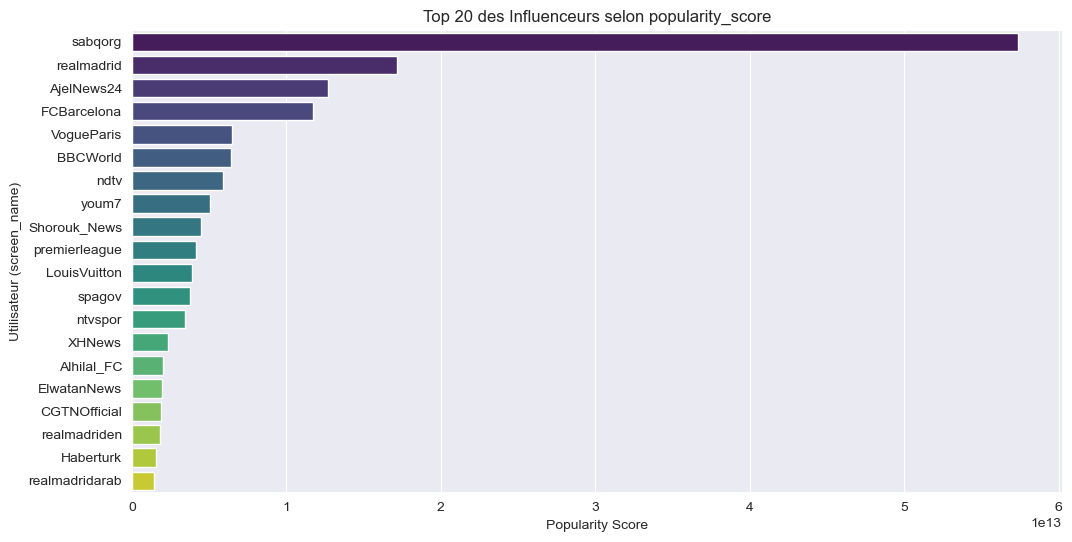

In [3]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_influencers, 
    y="screen_name", 
    x="popularity_score", 
    palette="viridis"
)
plt.title("Top 20 des Influenceurs selon popularity_score")
plt.xlabel("Popularity Score")
plt.ylabel("Utilisateur (screen_name)")
plt.show()


In [4]:
def user_segment(row):
    if row["popularity_score"] > 1e6:
        return "Influenceur majeur"
    elif row["tweets_per_day"] > 5:
        return "Utilisateur actif"
    else:
        return "Utilisateur régulier"

df_users["segment"] = df_users.apply(user_segment, axis=1)
display(df_users["segment"].value_counts())


segment
Utilisateur régulier    200935
Utilisateur actif        61370
Influenceur majeur        5163
Name: count, dtype: int64

In [1]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
from datetime import datetime, timezone
from collections import defaultdict
from tqdm import tqdm  # Pour suivre l’avancement

# Connexion MongoDB avec timeout long
client = MongoClient("localhost", 27017, connectTimeoutMS=60000, socketTimeoutMS=60000)
db = client["IF29_twitter_db"]
user_col = db["twitter_users"]
tweets_col = db["tweets_global"]

# --- Chargement des utilisateurs (plus léger que les tweets) ---
users = list(user_col.find({}, {"id_str": 1}))
df_users = pd.DataFrame(users)
df_users["user_id"] = df_users["id_str"]

print(f" {len(df_users)} utilisateurs chargés.")

# --- Initialisation des stats ---
stats_dict = defaultdict(lambda: {
    "text_lengths": [],
    "hashtags": [],
    "mentions": [],
    "urls": [],
    "retweets": [],
    "replies": [],
    "count": 0
})

# --- Traitement par batch du curseur Mongo ---
print(" Traitement des tweets par lots...")

cursor = tweets_col.find({}, {
    "user.id_str": 1,
    "text": 1,
    "entities.hashtags": 1,
    "entities.user_mentions": 1,
    "entities.urls": 1,
    "retweet_count": 1,
    "reply_count": 1
}).batch_size(1000)

processed = 0
try:
    for tweet in tqdm(cursor, desc="⏳ Analyse en cours"):
        user = tweet.get("user")
        if not user or not isinstance(user, dict):
            continue

        user_id = user.get("id_str")
        if not user_id:
            continue

        stats = stats_dict[user_id]
        stats["text_lengths"].append(len(tweet.get("text", "")))
        stats["hashtags"].append(len(tweet.get("entities", {}).get("hashtags", [])))
        stats["mentions"].append(len(tweet.get("entities", {}).get("user_mentions", [])))
        stats["urls"].append(len(tweet.get("entities", {}).get("urls", [])))
        stats["retweets"].append(tweet.get("retweet_count", 0))
        stats["replies"].append(tweet.get("reply_count", 0))
        stats["count"] += 1

        processed += 1
finally:
    cursor.close()

print(f" {processed} tweets traités.")

# --- Mise à jour de la base MongoDB ---
print("🛠️ Mise à jour de MongoDB utilisateur par utilisateur...")

for user in tqdm(df_users.itertuples(), total=len(df_users), desc="🔁 Mise à jour utilisateurs"):
    user_id = user.user_id
    mongo_id = user._1  # équivaut à row["_id"]

    stats = stats_dict.get(user_id)
    if not stats or stats["count"] == 0:
        continue

    tweet_stats = {
        "avg_text_length": np.mean(stats["text_lengths"]),
        "avg_num_hashtags": np.mean(stats["hashtags"]),
        "avg_num_mentions": np.mean(stats["mentions"]),
        "avg_num_urls": np.mean(stats["urls"]),
        "avg_retweet_count": np.mean(stats["retweets"]),
        "avg_reply_count": np.mean(stats["replies"]),
        "tweet_count": stats["count"]
    }

    user_col.update_one(
        {"_id": mongo_id},
        {"$set": tweet_stats}
    )

print(" Mise à jour terminée avec succès !")


 267468 utilisateurs chargés.
 Traitement des tweets par lots...


⏳ Analyse en cours: 1607996it [00:55, 28739.89it/s]


 1607996 tweets traités.
🛠️ Mise à jour de MongoDB utilisateur par utilisateur...


🔁 Mise à jour utilisateurs: 100%|██████████| 267468/267468 [01:53<00:00, 2349.60it/s]

 Mise à jour terminée avec succès !


C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)
C:\Users\MSI\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


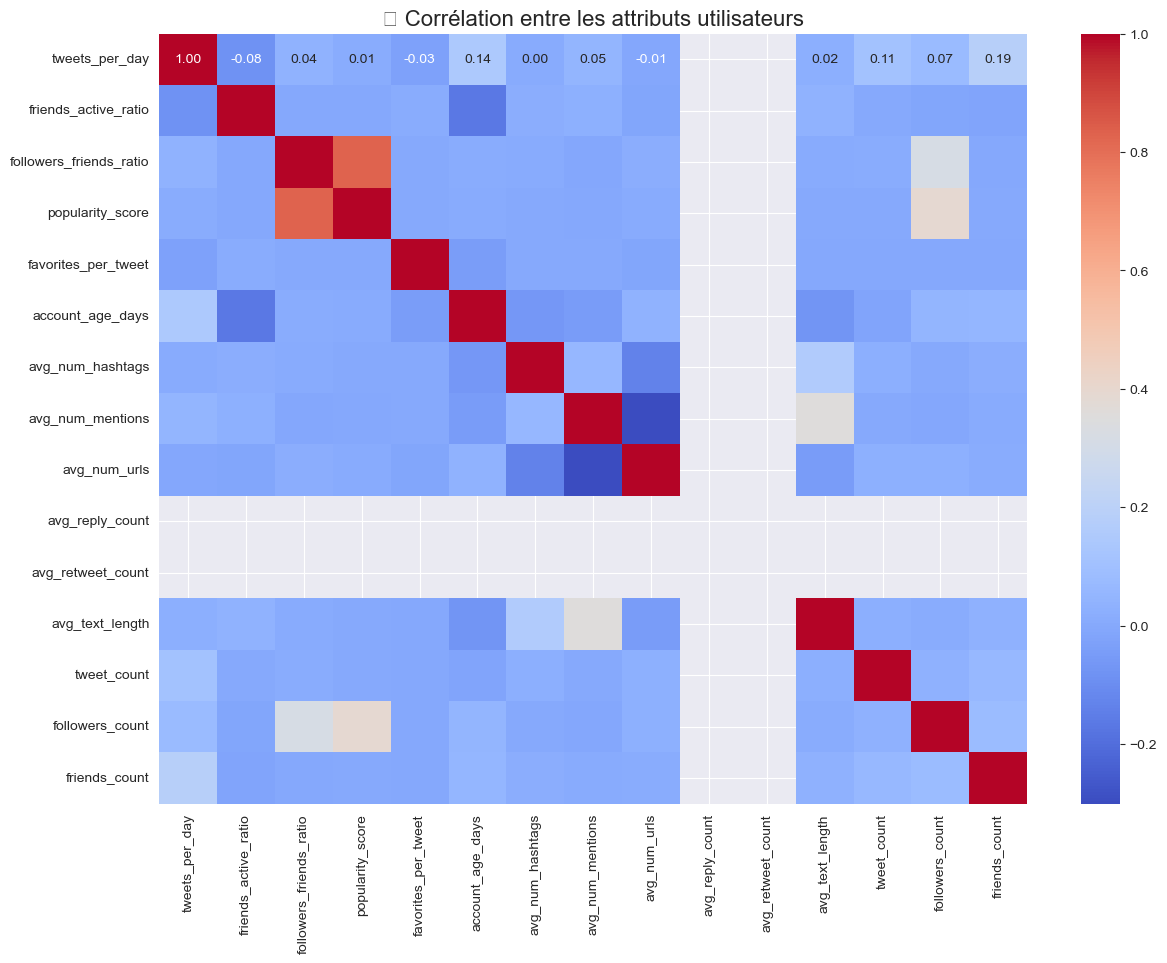

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


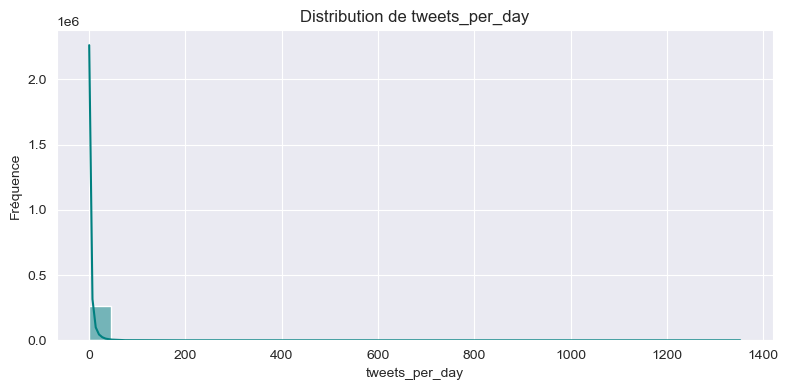

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


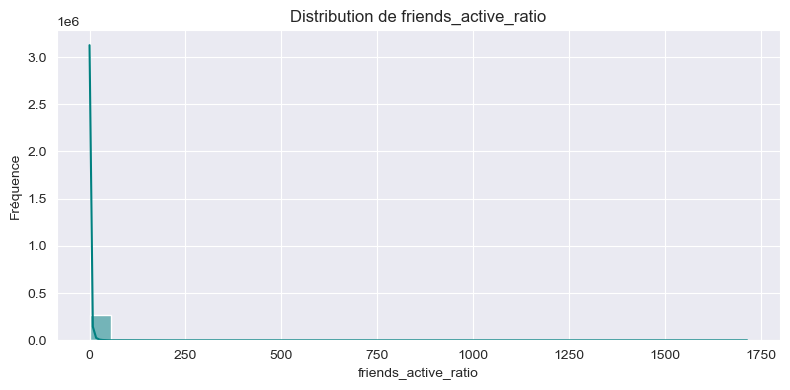

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


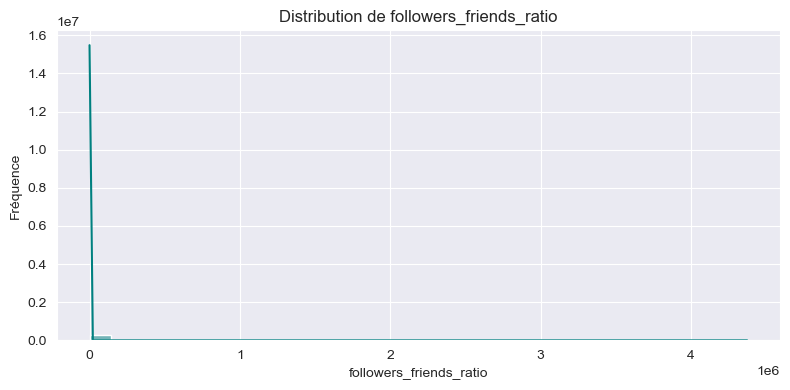

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


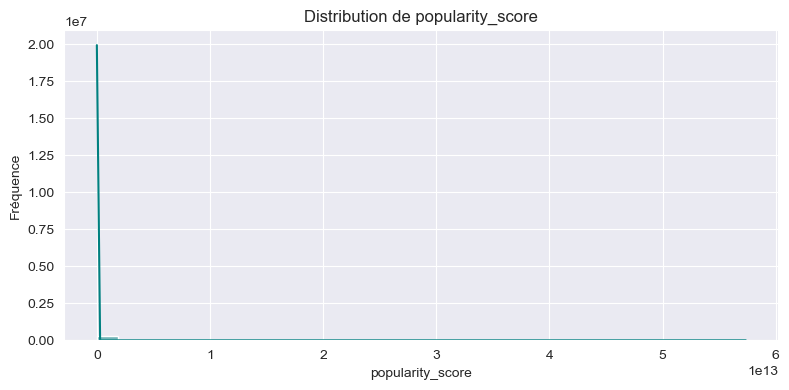

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


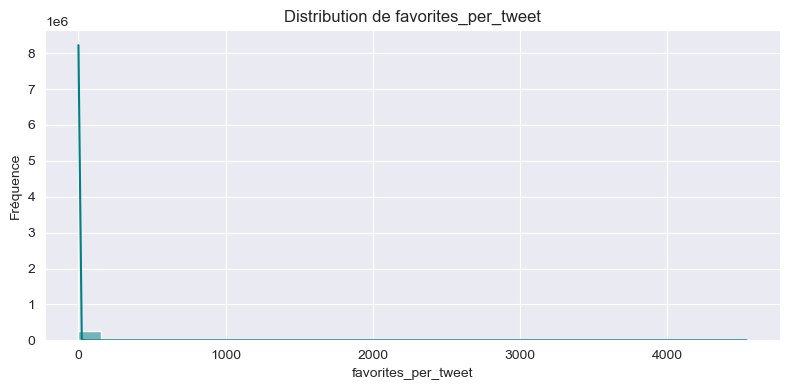

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


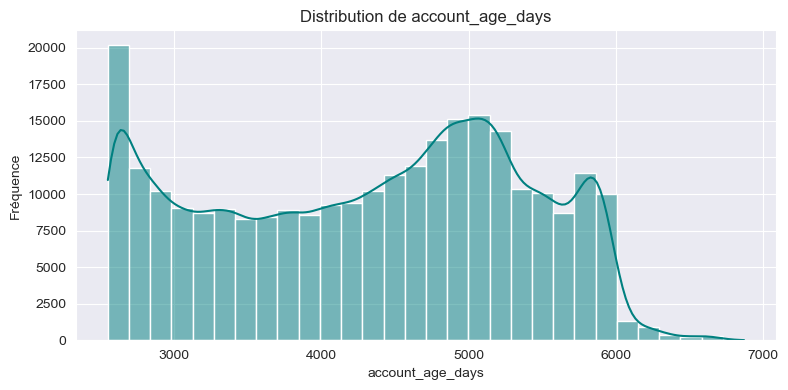

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


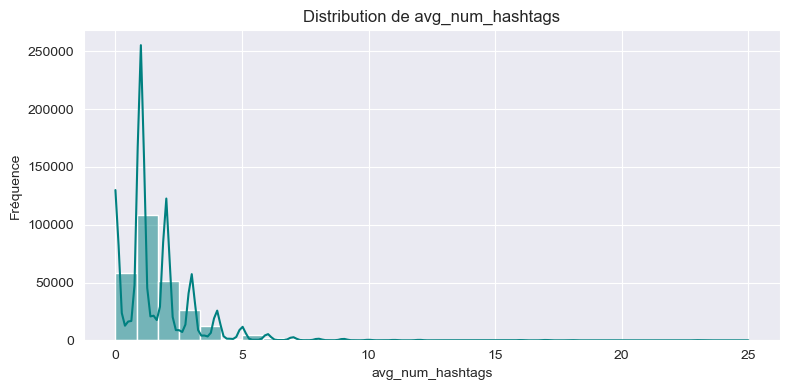

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


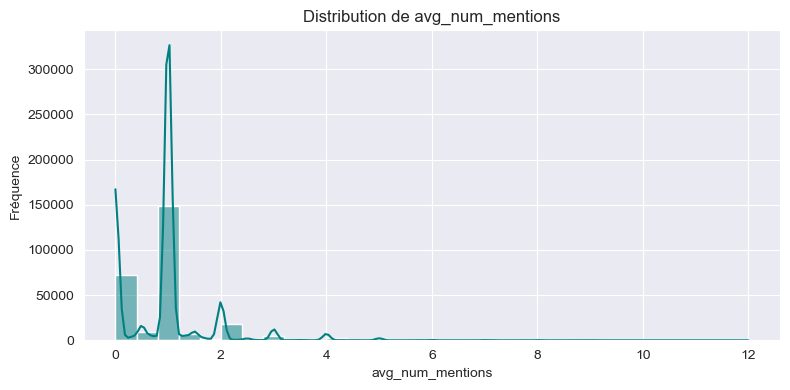

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


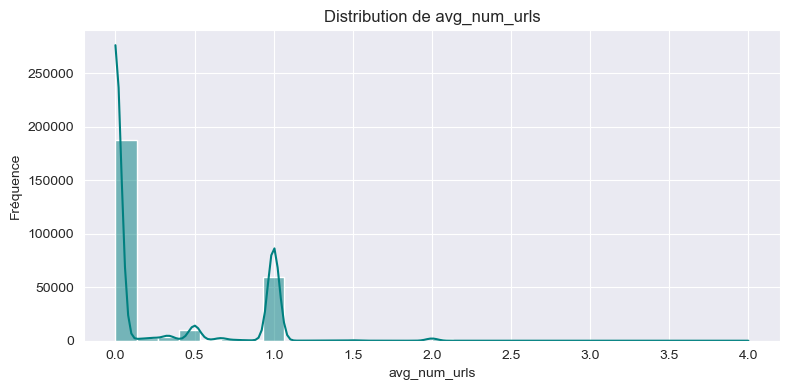

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


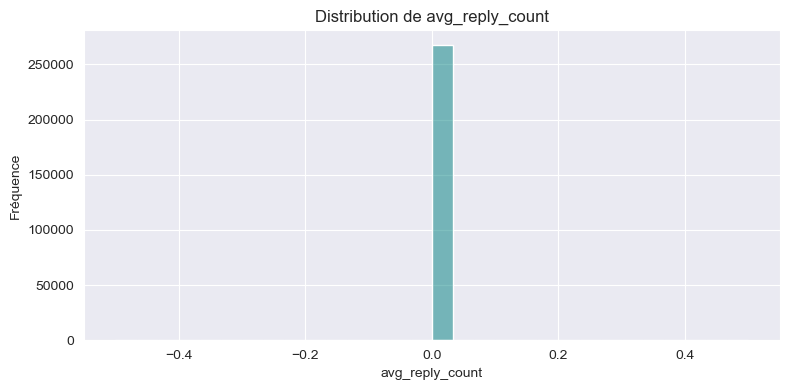

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


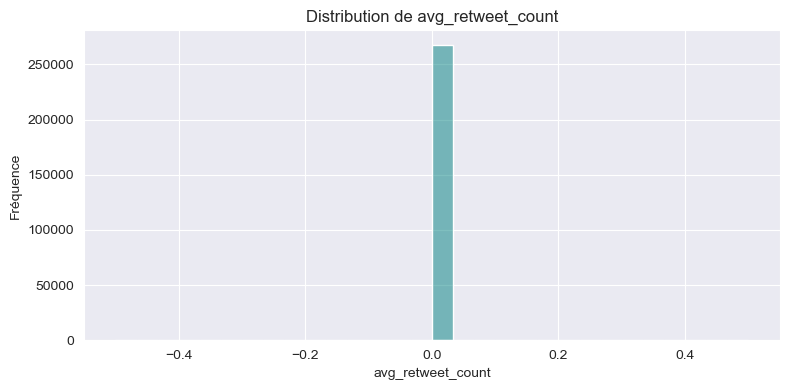

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


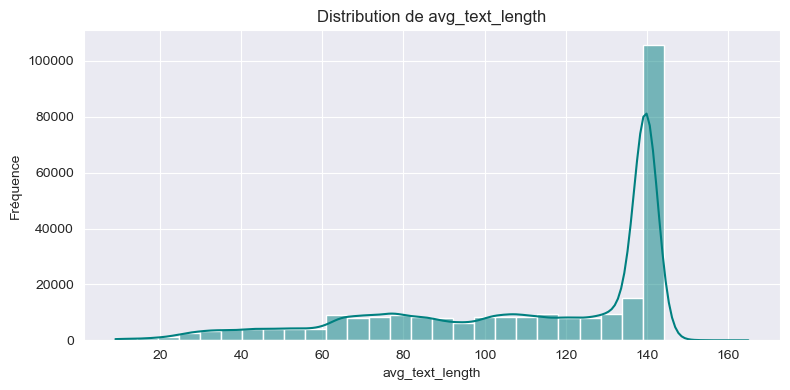

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


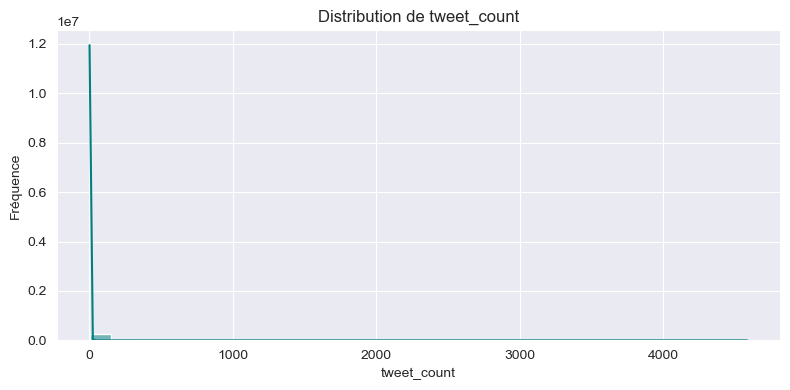

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


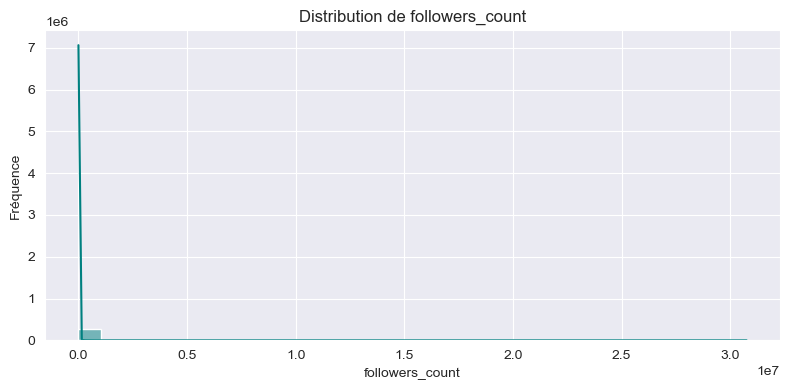

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


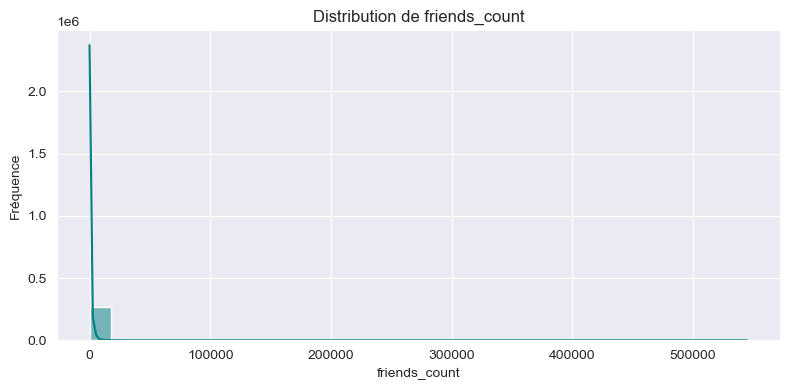

In [4]:
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#  Connexion à MongoDB
client = MongoClient("localhost", 27017)
db = client["IF29_twitter_db"]
user_col = db["twitter_users"]

#  Chargement des utilisateurs
users = list(user_col.find())
df_users = pd.DataFrame(users)

#  Liste des colonnes utiles
cols_to_try = [
    "tweets_per_day", "friends_active_ratio", "followers_friends_ratio", 
    "popularity_score", "favorites_per_tweet", "account_age_days",
    "avg_num_hashtags", "avg_num_mentions", "avg_num_urls",
    "avg_reply_count", "avg_retweet_count", "avg_text_length",
    "tweet_count", "followers_count", "friends_count"
]

#  Sélection uniquement des colonnes existantes
cols_to_use = [col for col in cols_to_try if col in df_users.columns]

#  Remplir les valeurs manquantes
df_analysis = df_users[cols_to_use].copy()
df_analysis = df_analysis.dropna()

#  Matrice de corrélation
plt.figure(figsize=(14, 10))
sns.heatmap(df_analysis.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("🔗 Corrélation entre les attributs utilisateurs", fontsize=16)
plt.show()

#  Graphiques de distributions pour repérer des comportements atypiques
for col in cols_to_use:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_analysis[col], kde=True, bins=30, color='teal')
    plt.title(f"Distribution de {col}")
    plt.xlabel(col)
    plt.ylabel("Fréquence")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



 Résumé statistique :
                                 mean           std          min          25%  \
tweets_per_day           4.768018e+00  1.118368e+01     0.000171     0.336529   
friends_active_ratio     2.593704e+00  7.550920e+00     0.000000     0.630952   
followers_friends_ratio  1.699535e+02  1.217053e+04     0.000000     0.374581   
popularity_score         6.973299e+08  1.244813e+11     0.000000    54.825021   
favorites_per_tweet      1.763617e+00  1.902211e+01     0.000000     0.102323   
account_age_days         4.309606e+03  1.041388e+03  2551.000000  3383.000000   
avg_num_hashtags         1.556521e+00  1.571211e+00     0.000000     1.000000   
avg_num_mentions         9.054422e-01  8.182850e-01     0.000000     0.000000   
avg_num_urls             2.670650e-01  4.392073e-01     0.000000     0.000000   
avg_reply_count          0.000000e+00  0.000000e+00     0.000000     0.000000   
avg_retweet_count        0.000000e+00  0.000000e+00     0.000000     0.000000   
avg_t

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


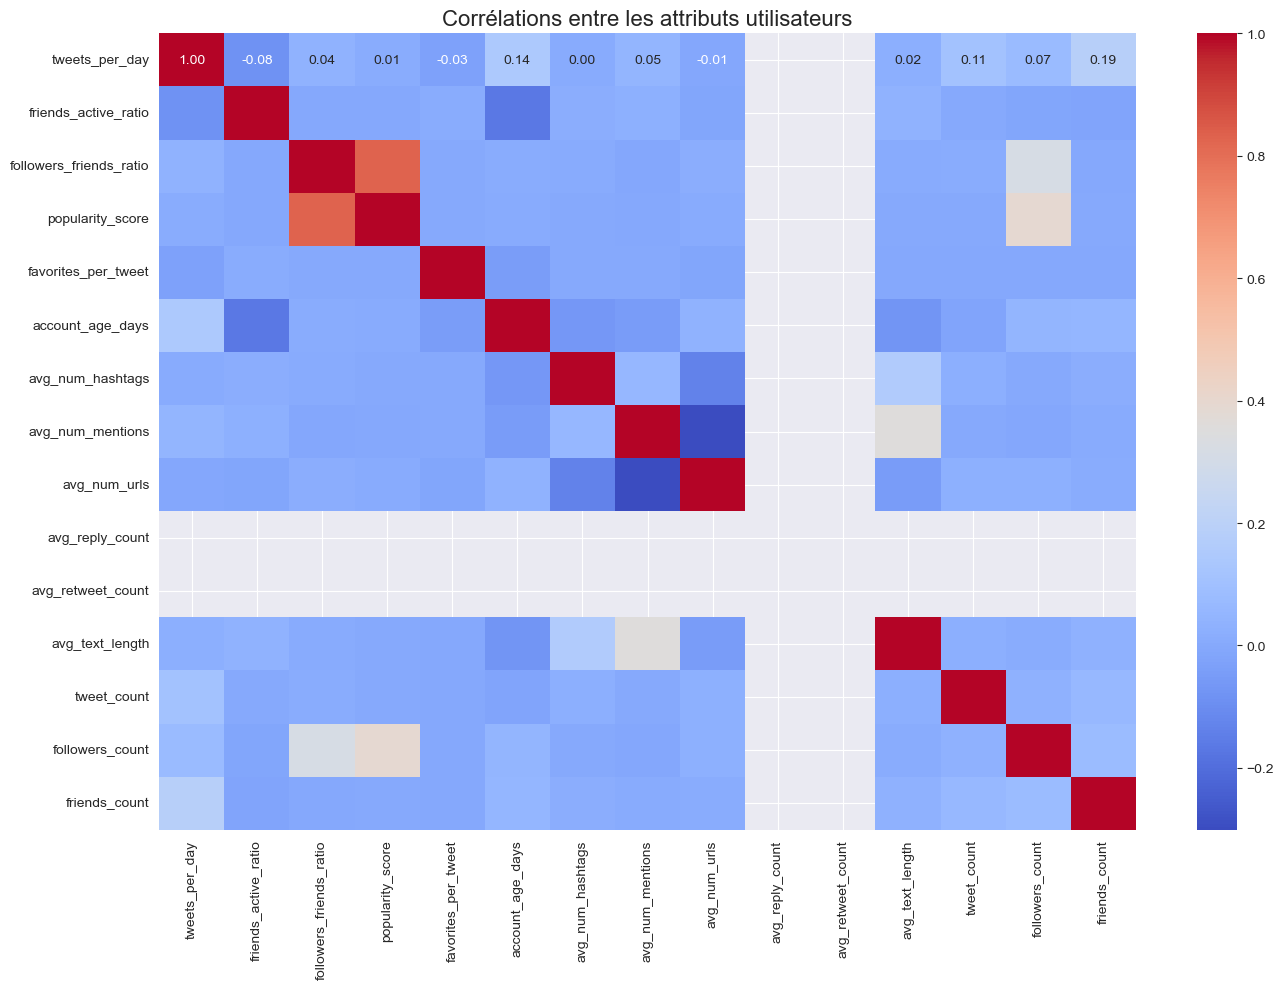

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


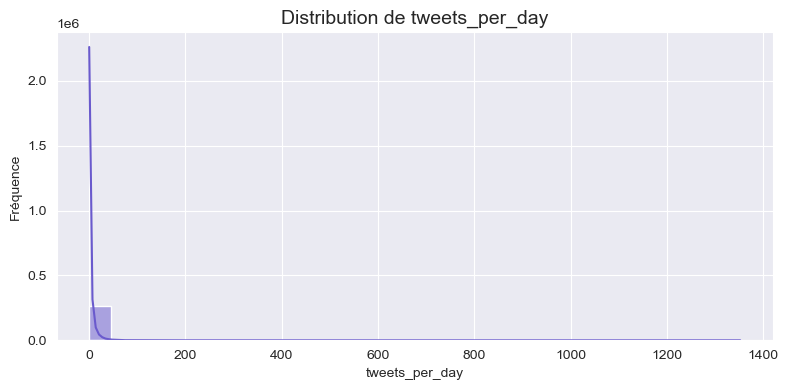

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


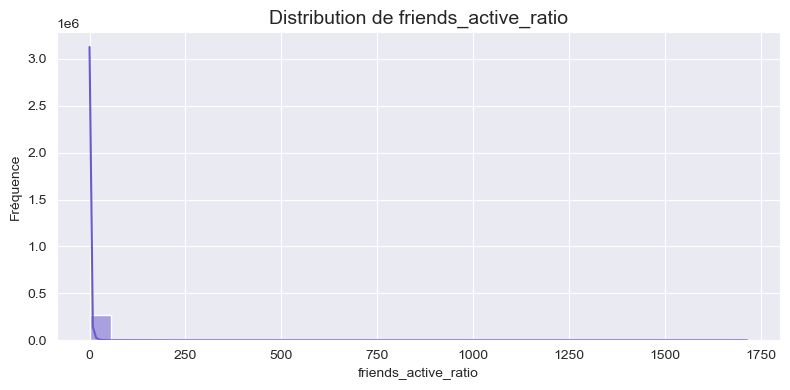

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


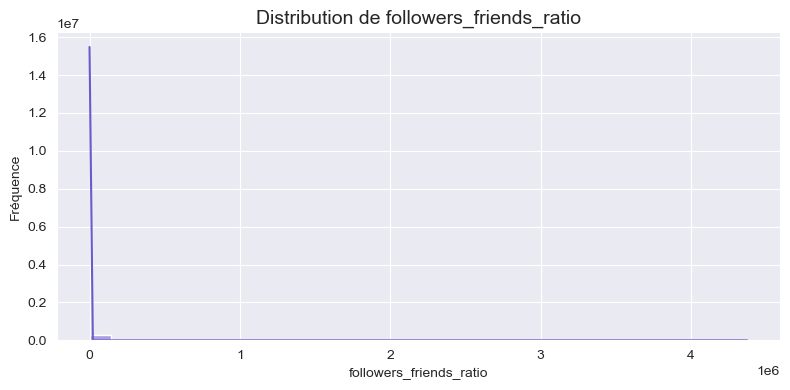

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


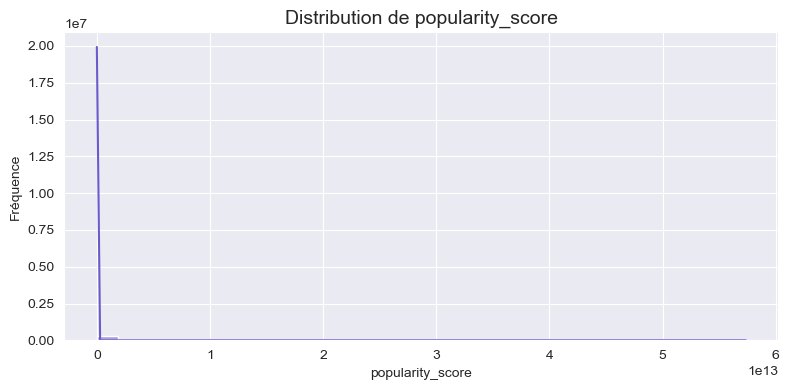

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


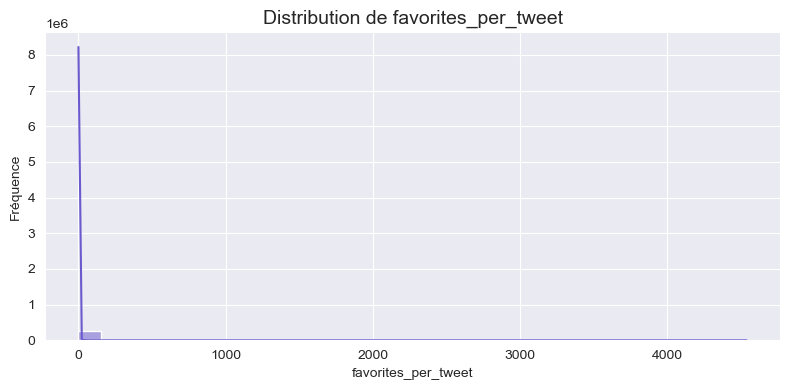

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


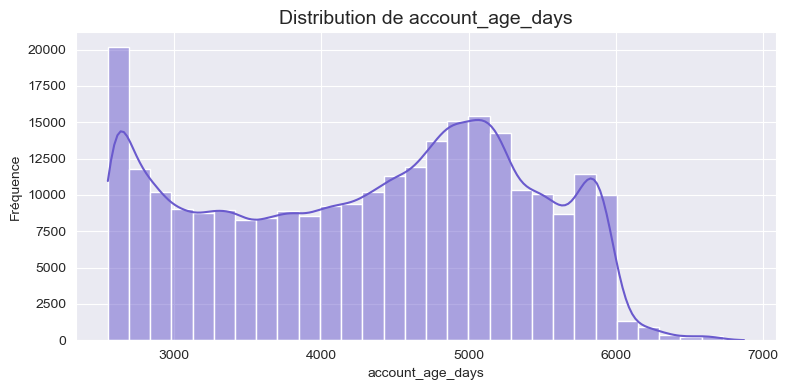

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


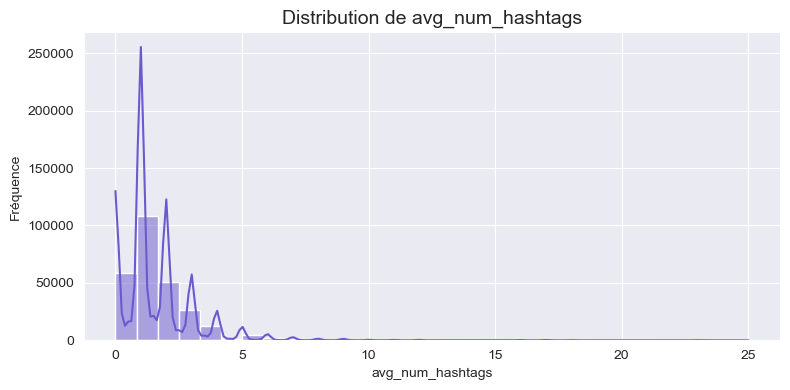

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


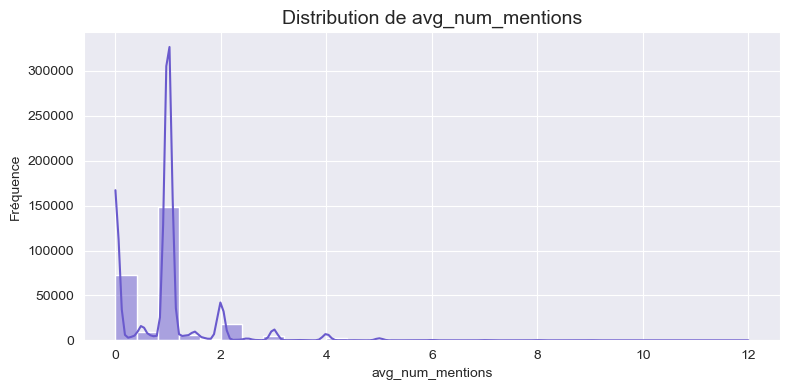

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


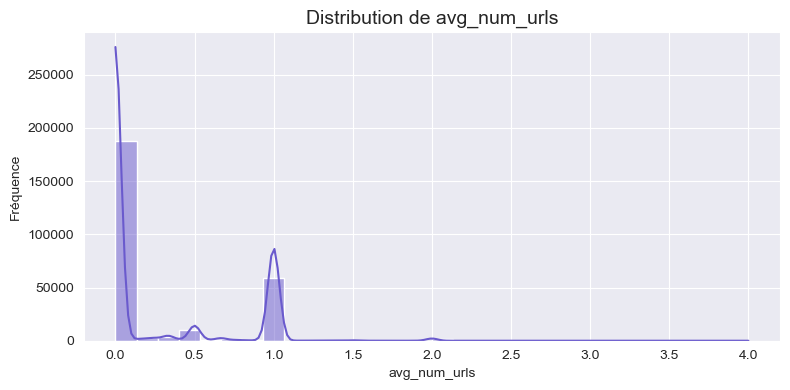

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


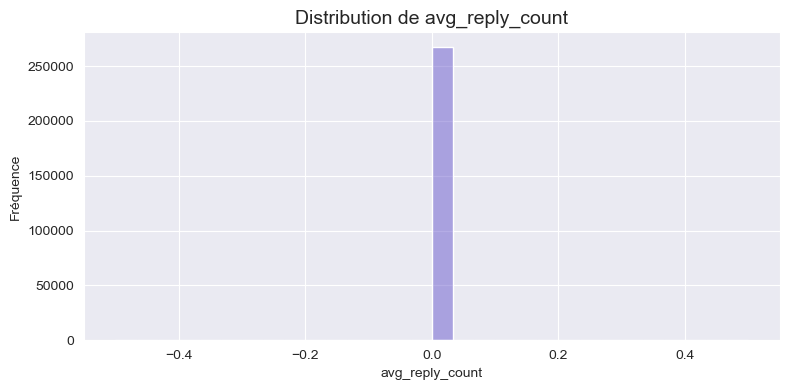

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


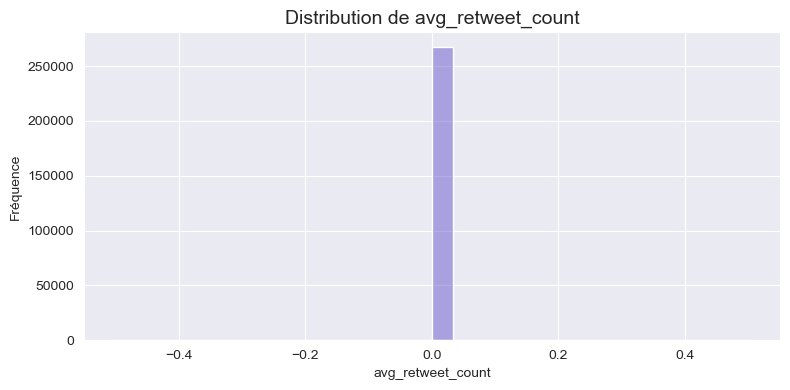

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


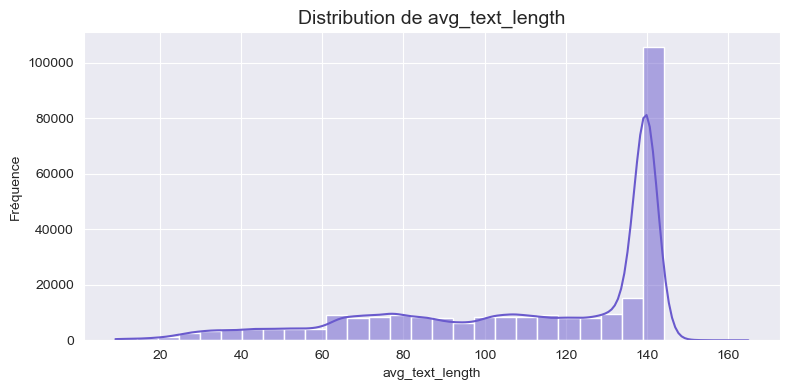

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


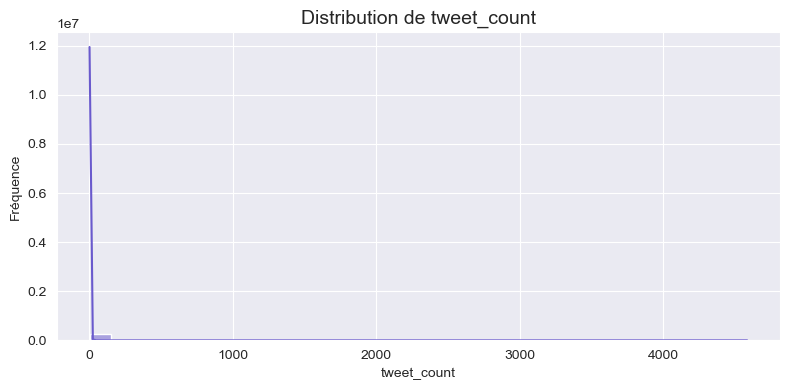

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


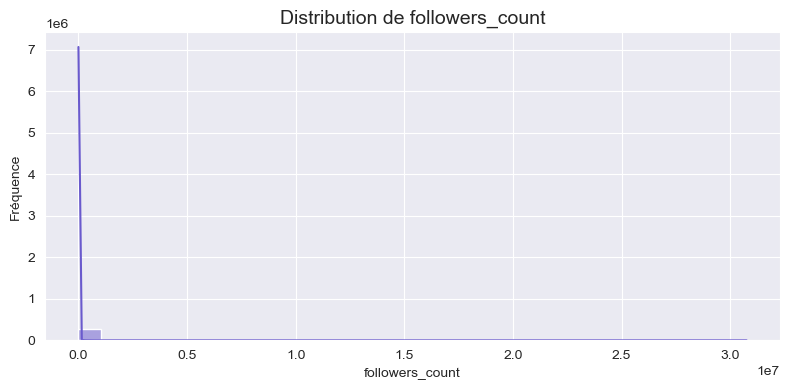

C:\Users\MSI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


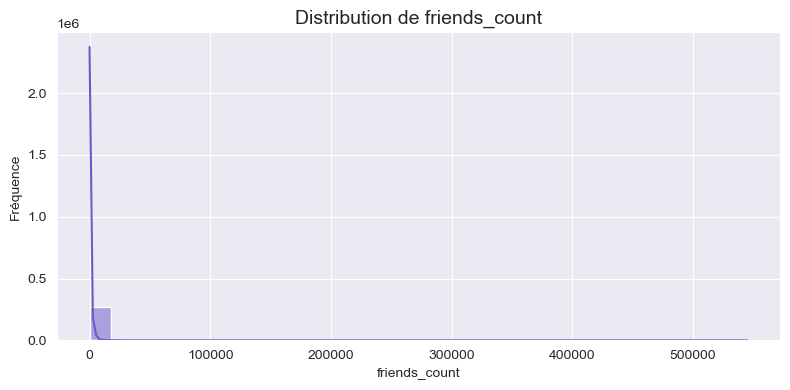

In [7]:
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Connexion MongoDB
client = MongoClient("localhost", 27017)
db = client["IF29_twitter_db"]
user_col = db["twitter_users"]

# Chargement des utilisateurs
users = list(user_col.find())
df_users = pd.DataFrame(users)

# Colonnes analytiques
cols_to_try = [
    "tweets_per_day", "friends_active_ratio", "followers_friends_ratio", 
    "popularity_score", "favorites_per_tweet", "account_age_days",
    "avg_num_hashtags", "avg_num_mentions", "avg_num_urls",
    "avg_reply_count", "avg_retweet_count", "avg_text_length",
    "tweet_count", "followers_count", "friends_count"
]

# Colonnes présentes dans les données
cols_to_use = [col for col in cols_to_try if col in df_users.columns]

# Nettoyage
df_analysis = df_users[cols_to_use].copy()
df_analysis.dropna(inplace=True)

# Résumé statistique (tu pourras me copier ça ensuite)
summary_stats = df_analysis.describe().transpose()
summary_stats["iqr"] = summary_stats["75%"] - summary_stats["25%"]
summary_stats["coef_var"] = summary_stats["std"] / summary_stats["mean"]

# Affichage du tableau
print("\n Résumé statistique :")
print(summary_stats[["mean", "std", "min", "25%", "50%", "75%", "max", "iqr", "coef_var"]])

#  Heatmap des corrélations
plt.figure(figsize=(14, 10))
sns.heatmap(df_analysis.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Corrélations entre les attributs utilisateurs", fontsize=16)
plt.tight_layout()
plt.show()

# Distribution des colonnes
for col in cols_to_use:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_analysis[col], kde=True, bins=30, color='slateblue')
    plt.title(f"Distribution de {col}", fontsize=14)
    plt.xlabel(col)
    plt.ylabel("Fréquence")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
